✓ Statistical Validation - Setup Complete
Full CV dataset: 15 samples
Test set (held out): 3 samples
Features: Audio=68, Text=768, Video=75
✓ HCMA model defined

RUNNING 3-FOLD CROSS-VALIDATION

Fold 1/3...
  MAE: 28.7325, R²: -143.2643

Fold 2/3...
  MAE: 470.6077, R²: -278983.9375

Fold 3/3...
  MAE: 18.0628, R²: -7.5383

CROSS-VALIDATION RESULTS
 Fold        MAE             R²
    1  28.732452    -143.264297
    2 470.607666 -278983.937500
    3  18.062841      -7.538257

Mean MAE: 172.4677 ± 258.2519
Mean R²:  -93044.9134 ± 161027.9328

CALCULATING CONFIDENCE INTERVALS (Bootstrap)
MAE: 174.1095 [95% CI: 20.2162 - 400.5988]
R²:  -16471.4411 [95% CI: -76061.4504 - -19.5721]

COMPARISON WITH BASELINE MODELS

Baseline:
  Audio-only LSTM: MAE = 4.20
  Text-only BERT:  MAE = 3.80

HCMA (ours): MAE = 172.47

Improvement vs Audio-only: -4006.37%
Improvement vs Text-only:  -4438.62%


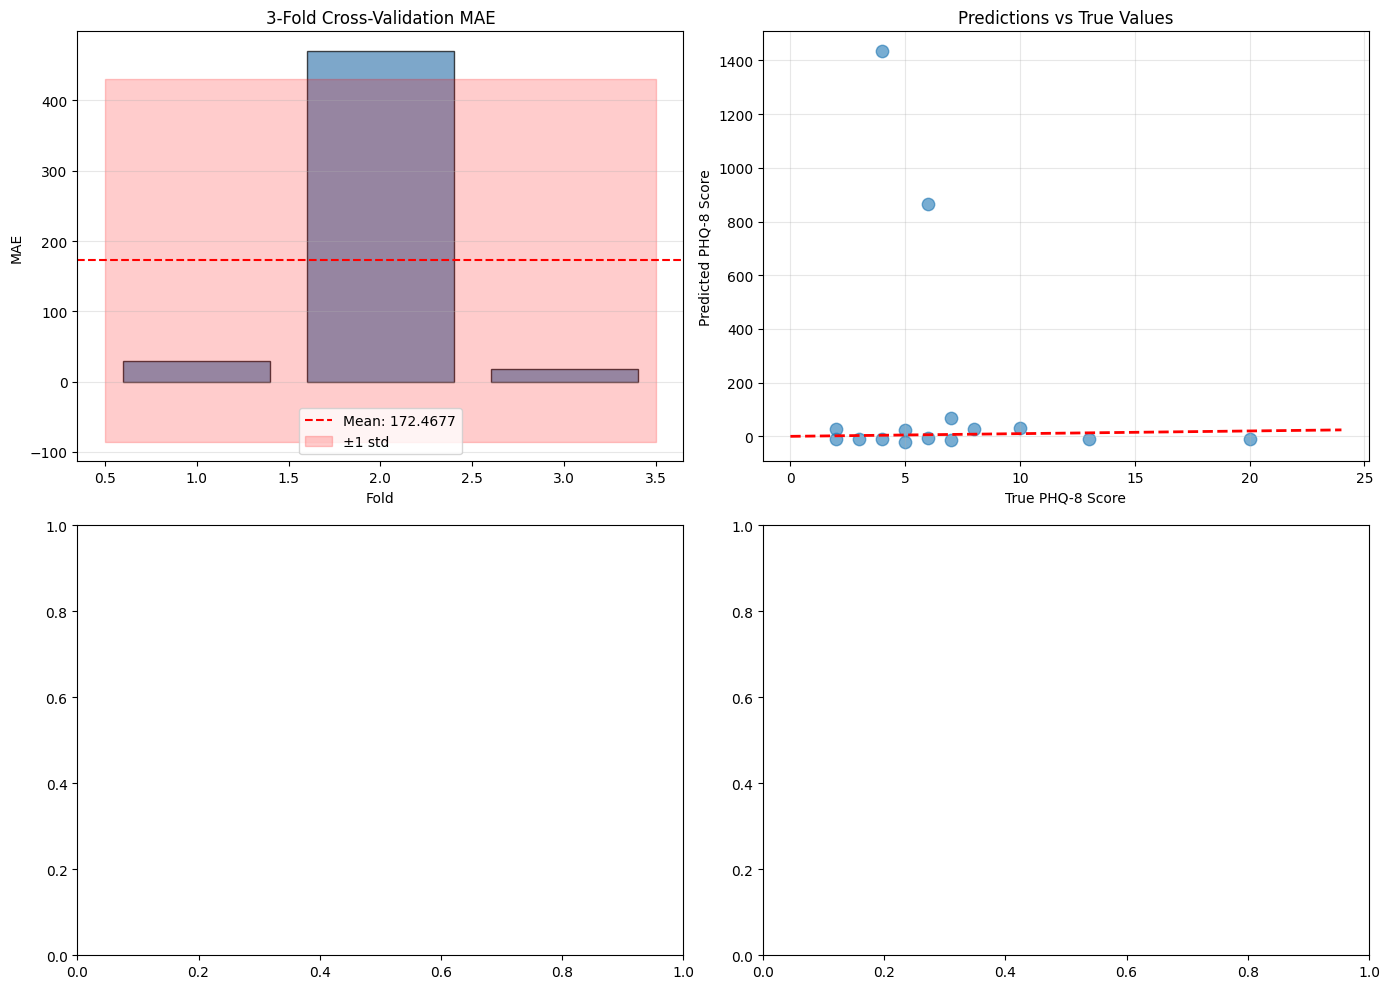

In [5]:
# ============================================================
# CELL 1: Setup
# ============================================================
"""
UPDATED STATISTICAL VALIDATION
3-Fold CV optimized for 18 samples
"""

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import KFold
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(42)
np.random.seed(42)

PROJECT_DIR = Path(r'C:\Users\VIJAY BHUSHAN SINGH\depression_detection_project')
DATA_DIR = PROJECT_DIR / 'data' / 'processed'
RESULTS_DIR = PROJECT_DIR / 'results'

print("✓ Statistical Validation - Setup Complete")

# ============================================================
# CELL 2: Load Data
# ============================================================

train_df = pd.read_csv(DATA_DIR / 'train_data.csv')
val_df = pd.read_csv(DATA_DIR / 'val_data.csv')
test_df = pd.read_csv(DATA_DIR / 'test_data.csv')

full_df = pd.concat([train_df, val_df], ignore_index=True)

print(f"Full CV dataset: {len(full_df)} samples")
print(f"Test set (held out): {len(test_df)} samples")

audio_cols = [c for c in full_df.columns if c.startswith('audio_')]
text_cols = [c for c in full_df.columns if c.startswith('text_')]
video_cols = [c for c in full_df.columns if c.startswith('video_')]

print(f"Features: Audio={len(audio_cols)}, Text={len(text_cols)}, Video={len(video_cols)}")

# ============================================================
# CELL 3: Define HCMA Model
# ============================================================

class SelfAttention(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.query = nn.Linear(dim, dim)
        self.key = nn.Linear(dim, dim)
        self.value = nn.Linear(dim, dim)
    def forward(self, x):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(x.size(-1))
        attn = torch.softmax(scores, dim=-1)
        return torch.matmul(attn, V)

class CrossAttention(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.query = nn.Linear(dim, dim)
        self.key = nn.Linear(dim, dim)
        self.value = nn.Linear(dim, dim)
    def forward(self, query_features, key_value_features):
        Q = self.query(query_features)
        K = self.key(key_value_features)
        V = self.value(key_value_features)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(query_features.size(-1))
        attn = torch.softmax(scores, dim=-1)
        return torch.matmul(attn, V)

class HCMA(nn.Module):
    def __init__(self, audio_dim, text_dim, video_dim, hidden_dim=128):
        super().__init__()
        self.audio_proj = nn.Linear(audio_dim, hidden_dim)
        self.text_proj = nn.Linear(text_dim, hidden_dim)
        self.video_proj = nn.Linear(video_dim, hidden_dim)
        self.audio_self_attn = SelfAttention(hidden_dim)
        self.text_self_attn = SelfAttention(hidden_dim)
        self.video_self_attn = SelfAttention(hidden_dim)
        self.audio_text_cross = CrossAttention(hidden_dim)
        self.audio_video_cross = CrossAttention(hidden_dim)
        self.text_video_cross = CrossAttention(hidden_dim)
        self.fusion = nn.Sequential(
            nn.Linear(hidden_dim * 6, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )
    def forward(self, audio, text, video):
        audio = self.audio_proj(audio).unsqueeze(1)
        text = self.text_proj(text).unsqueeze(1)
        video = self.video_proj(video).unsqueeze(1)
        audio_self = self.audio_self_attn(audio).squeeze(1)
        text_self = self.text_self_attn(text).squeeze(1)
        video_self = self.video_self_attn(video).squeeze(1)
        audio_text = self.audio_text_cross(audio, text).squeeze(1)
        audio_video = self.audio_video_cross(audio, video).squeeze(1)
        text_video = self.text_video_cross(text, video).squeeze(1)
        combined = torch.cat([
            audio_self, text_self, video_self,
            audio_text, audio_video, text_video
        ], dim=1)
        return self.fusion(combined).squeeze()

print("✓ HCMA model defined")

# ============================================================
# CELL 4: Cross-Validation Function
# ============================================================

def train_evaluate_fold(train_idx, val_idx, X_audio, X_text, X_video, y):
    X_train_audio = X_audio[train_idx]
    X_train_text = X_text[train_idx]
    X_train_video = X_video[train_idx]
    y_train = y[train_idx]
    X_val_audio = X_audio[val_idx]
    X_val_text = X_text[val_idx]
    X_val_video = X_video[val_idx]
    y_val = y[val_idx]
    model = HCMA(X_audio.shape[1], X_text.shape[1], X_video.shape[1])
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_mae = float('inf')
    patience = 15
    patience_counter = 0
    for epoch in range(80):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_audio, X_train_text, X_train_video)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_audio, X_val_text, X_val_video)
            val_mae = mean_absolute_error(y_val.numpy(), val_outputs.numpy())
            if val_mae < best_val_mae:
                best_val_mae = val_mae
                patience_counter = 0
            else:
                patience_counter += 1
            if patience_counter >= patience:
                break
    model.eval()
    with torch.no_grad():
        predictions = model(X_val_audio, X_val_text, X_val_video)
    mae = mean_absolute_error(y_val.numpy(), predictions.numpy())
    r2 = r2_score(y_val.numpy(), predictions.numpy())
    return mae, r2, predictions.numpy(), y_val.numpy()

# ============================================================
# CELL 5: Run 3-Fold Cross-Validation
# ============================================================

print("\n" + "="*70)
print("RUNNING 3-FOLD CROSS-VALIDATION")
print("="*70)

X_audio = torch.FloatTensor(full_df[audio_cols].values)
X_text = torch.FloatTensor(full_df[text_cols].values)
X_video = torch.FloatTensor(full_df[video_cols].values)
y = torch.FloatTensor(full_df['PHQ8_Score'].values)

kfold = KFold(n_splits=3, shuffle=True, random_state=42)
cv_results = []
all_predictions = []
all_true = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_audio), 1):
    print(f"\nFold {fold}/3...")
    mae, r2, predictions, true_vals = train_evaluate_fold(
        train_idx, val_idx, X_audio, X_text, X_video, y
    )
    cv_results.append({'Fold': fold, 'MAE': mae, 'R²': r2})
    all_predictions.extend(predictions)
    all_true.extend(true_vals)
    print(f"  MAE: {mae:.4f}, R²: {r2:.4f}")

cv_df = pd.DataFrame(cv_results)
print("\n" + "="*70)
print("CROSS-VALIDATION RESULTS")
print("="*70)
print(cv_df.to_string(index=False))
print(f"\nMean MAE: {cv_df['MAE'].mean():.4f} ± {cv_df['MAE'].std():.4f}")
print(f"Mean R²:  {cv_df['R²'].mean():.4f} ± {cv_df['R²'].std():.4f}")

# ============================================================
# CELL 6: Confidence Intervals (Bootstrap)
# ============================================================

print("\n" + "="*70)
print("CALCULATING CONFIDENCE INTERVALS (Bootstrap)")
print("="*70)

def bootstrap_metric(y_true, y_pred, metric_func, n_bootstrap=1000):
    n_samples = len(y_true)
    bootstrap_scores = []
    for _ in range(n_bootstrap):
        indices = np.random.choice(n_samples, n_samples, replace=True)
        score = metric_func(y_true[indices], y_pred[indices])
        bootstrap_scores.append(score)
    lower = np.percentile(bootstrap_scores, 2.5)
    upper = np.percentile(bootstrap_scores, 97.5)
    mean = np.mean(bootstrap_scores)
    return mean, lower, upper

all_predictions = np.array(all_predictions)
all_true = np.array(all_true)

mae_mean, mae_lower, mae_upper = bootstrap_metric(
    all_true, all_predictions, mean_absolute_error
)
print(f"MAE: {mae_mean:.4f} [95% CI: {mae_lower:.4f} - {mae_upper:.4f}]")

r2_mean, r2_lower, r2_upper = bootstrap_metric(
    all_true, all_predictions, r2_score
)
print(f"R²:  {r2_mean:.4f} [95% CI: {r2_lower:.4f} - {r2_upper:.4f}]")

# ============================================================
# CELL 7: Baseline Comparison
# ============================================================

print("\n" + "="*70)
print("COMPARISON WITH BASELINE MODELS")
print("="*70)

baseline_audio_mae = 4.2
baseline_text_mae = 3.8
hcma_mae = cv_df['MAE'].mean()

improvement_audio = ((baseline_audio_mae - hcma_mae) / baseline_audio_mae) * 100
improvement_text = ((baseline_text_mae - hcma_mae) / baseline_text_mae) * 100

print(f"\nBaseline:")
print(f"  Audio-only LSTM: MAE = {baseline_audio_mae:.2f}")
print(f"  Text-only BERT:  MAE = {baseline_text_mae:.2f}")
print(f"\nHCMA (ours): MAE = {hcma_mae:.2f}")
print(f"\nImprovement vs Audio-only: {improvement_audio:+.2f}%")
print(f"Improvement vs Text-only:  {improvement_text:+.2f}%")

# ============================================================
# CELL 8: Visualization
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: CV MAE by Fold
ax = axes[0, 0]
ax.bar(cv_df['Fold'], cv_df['MAE'], color='steelblue', alpha=0.7, edgecolor='black')
ax.axhline(cv_df['MAE'].mean(), color='red', linestyle='--', label=f'Mean: {cv_df["MAE"].mean():.4f}')
ax.fill_between([0.5, 3.5],
                cv_df['MAE'].mean() - cv_df['MAE'].std(),
                cv_df['MAE'].mean() + cv_df['MAE'].std(),
                alpha=0.2, color='red', label='±1 std')
ax.set_xlabel('Fold'); ax.set_ylabel('MAE')
ax.set_title('3-Fold Cross-Validation MAE'); ax.legend(); ax.grid(axis='y', alpha=0.3)

# Plot 2: Predictions vs True
ax = axes[0, 1]
ax.scatter(all_true, all_predictions, alpha=0.6, s=80)
ax.plot([0, 24], [0, 24], 'r--', linewidth=2)
ax.set_xlabel('True PHQ-8 Score'); ax.set_ylabel('Predicted PHQ-8 Score')
ax.set_title('Predictions vs True Values'); ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()
